In [21]:
import scipy.io
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
from scipy.signal import firwin, butter, buttord, freqz

from arrus.ops.us4r import *
from arrus.ops.imaging import *
from arrus.metadata import *
from arrus.devices.probe import *
from arrus.devices.us4r import Us4RDTO
from arrus.utils.imaging import *

In [22]:
data = scipy.io.loadmat("../Datasets/2022-09-13-13-38-31_id365.mat")
data["rf_data"].shape
rf = data["rf_data"]
rf = rf[np.newaxis, ...]
rf.shape

(1, 150, 4224, 128)

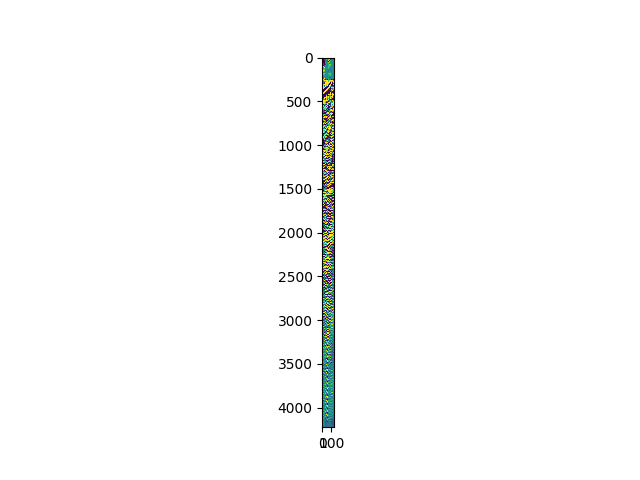

In [23]:
%matplotlib widget
plt.imshow(np.squeeze(rf)[0], vmin=-1000, vmax=1000)

## Metadane: kontekst akwizycji: sekwencja, jakie urządzenie etc.

In [24]:
tx_angles = np.tile([-4.0, 0.0, 4.0], 50)*np.pi/180

sequence = PwiSequence(
    pulse=Pulse(center_frequency=4.4e6, n_periods=2, inverse=False),
    rx_sample_range=(0, rf.shape[1]),
    speed_of_sound=1540, # [m/s],
    angles=tx_angles,
    pri=100e-6
)

model=ProbeModel(
    model_id=ProbeModelId("atl", "l7-4"),
    n_elements=128,
    pitch=0.298e-3,
    curvature_radius=0,
)

probe = ProbeDTO(
    model=model
)

device=Us4RDTO(
    sampling_frequency=65e6,
    probe=probe
)

context = arrus.metadata.FrameAcquisitionContext(
    device=device, 
    sequence=sequence,
    raw_sequence=None,
    medium=None,
    custom_data={})

data_desc=EchoDataDescription(
    sampling_frequency=65e6,
)

metadata = ConstMetadata(context=context, data_desc=data_desc, input_shape=rf.shape, is_iq_data=False, dtype=np.int16, version=None)

In [25]:
#Example custom operation class definition
class SWDetection(Operation):
    """
    """
    def __init__(self):
        pass

    def prepare(self, const_metadata):
        # liczba probek
        # fs
        # fs = 65e6
        fs = const_metadata.data_description.sampling_frequency
        # xp = self.xp
        # fs = const_metadata.data_description.sampling_frequency
        # fc = _get_unique_pulse(const_metadata.context.sequence).center_frequency
        # input_shape = const_metadata.input_shape
        # n_samples = input_shape[-1]
        # if n_samples == 0:
        #     raise ValueError("Empty array is not accepted.")
        # t = (xp.arange(0, n_samples) / fs).reshape(1, 1, -1)
        # self.mod_factor = (2 * xp.cos(-2 * xp.pi * fc * t)
        #                    + 2 * xp.sin(-2 * xp.pi * fc * t) * 1j)
        # self.mod_factor = self.mod_factor.astype(xp.complex64)
        # return const_metadata.copy(is_iq_data=True, dtype="complex64")
        return const_metadata
        
    def process(self, data):
        return data**2

### Design filters

In [26]:
# Function to plot the filter response
def plot_FIR_response(fs, taps, w, h):
    "Utility function to plot response functions"
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(8, 9))
    ax0.plot(range(len(taps)), taps)
    ax0.set_xlabel("Tap")
    ax0.set_ylabel("Value")
    
    ax1.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)))
    ax1.set_ylim(-80, 5)
    ax1.set_xlim(0, 0.5*fs)
    ax1.grid(True)
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Gain (dB)')
    
    ax2.plot(0.5*fs*w/np.pi, np.angle(h))
    ax2.set_xlim(0, 0.5*fs)
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("Phase (rad)")

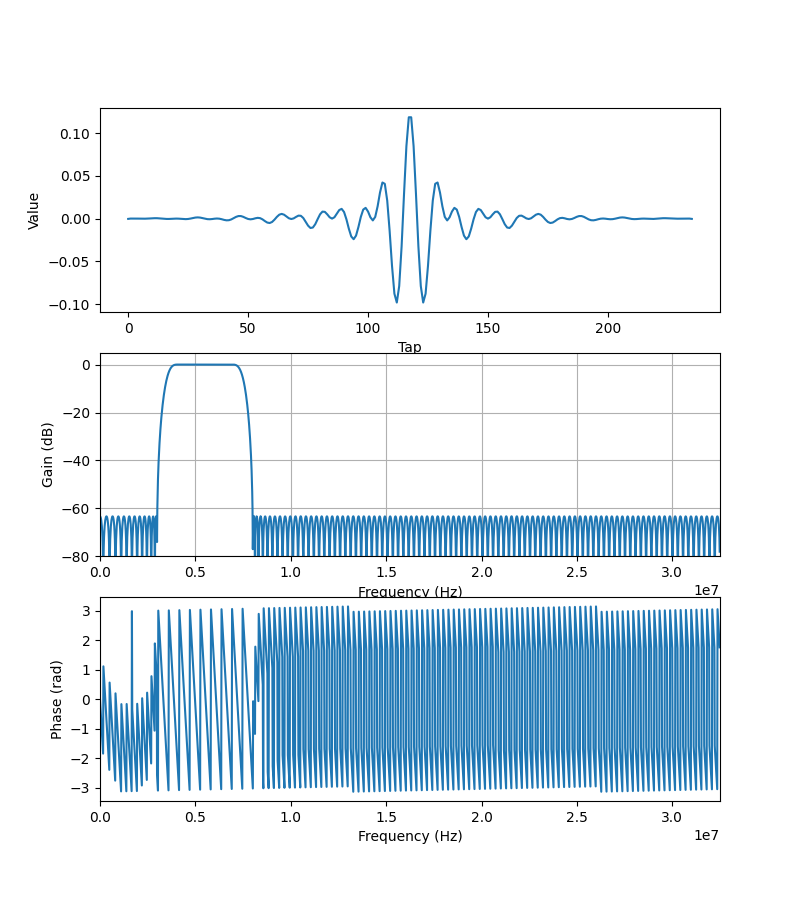

In [27]:
## Design a band-pass FIR filter for RF filtering of raw channel data

import_RF_filter_taps = 0    # Set to '1' to import filter taps from a file. If '0' a filter will be designed.

if(import_RF_filter_taps):
    # Import RF Band-pass FIR Filter coefficients
    RF_Filter_coeffs = scipy.io.loadmat("RF_Filter_coeffs.mat")
    rf_fir_taps = RF_Filter_coeffs["coeffs"]
    rf_fir_taps = np.squeeze(rf_fir_taps)
    
else:
    # Design a filter from the specification
    fs = 65e6            # Sample rate, Hz
    band = [4e6, 7e6]    # Desired pass band, Hz
    trans_width = 1e6    # Width of transition from pass band to stop band, Hz
    numtaps = 236        # Size of the FIR filter.

    edges = [0, band[0] - trans_width, band[0], band[1], band[1] + trans_width, 0.5*fs]
    rf_fir_taps = signal.remez(numtaps, edges, [0, 1, 0], Hz=fs)
    if(1):
        w, h = signal.freqz(rf_fir_taps, [1], worN=2000)
        plot_FIR_response(fs, rf_fir_taps, w, h)


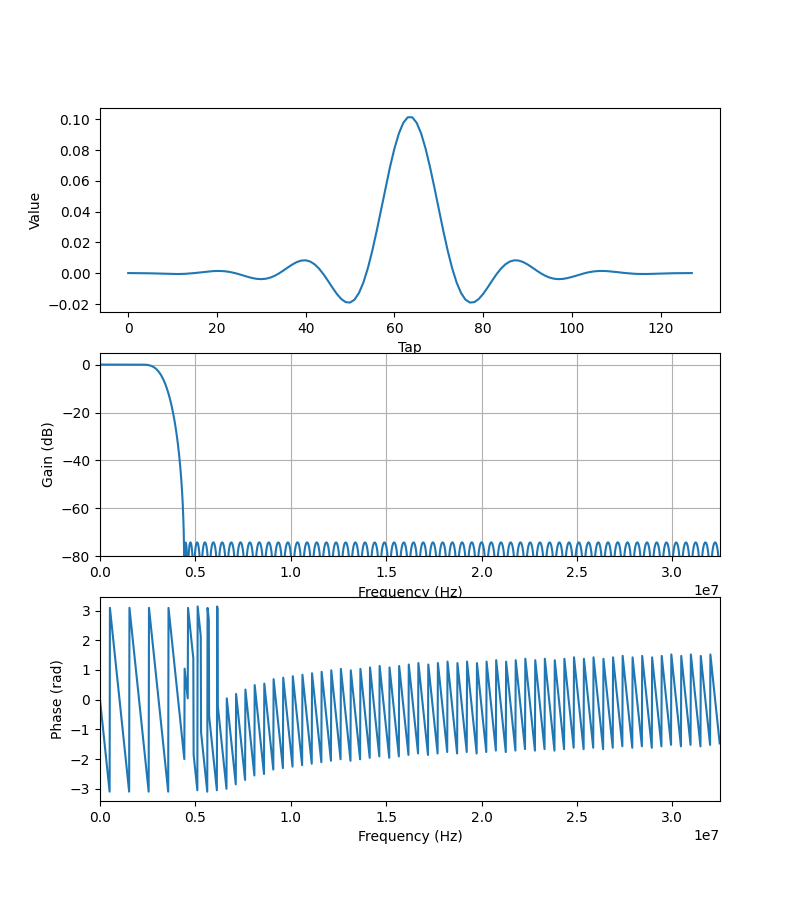

In [28]:
## Design a low-pass FIR filter for filtering of down-conversion products

# Specify the filter parameters    
fs = 65e6                  # Sample rate, Hz
cutoff = 0.5 * 4.4e6       # Desired cutoff frequency, Hz
trans_width = 0.5 * 4.4e6  # Width of transition from pass band to stop band, Hz
numtaps = 128              # Size of the FIR filter.
iq_fir_taps = signal.remez(numtaps, [0, cutoff, cutoff + trans_width, 0.5*fs], [1, 0], Hz=fs)
if(1):
    w, h = signal.freqz(iq_fir_taps, [1], worN=2000)
    plot_FIR_response(fs, iq_fir_taps, w, h)    


## Pipeline: RF Filtering, Down-conversion and Beamforming

In [29]:
# Define the grid for beamforming
x_grid = np.arange(-20, 20, 0.1) * 1e-3
z_grid = np.arange(0, 50, 0.1) * 1e-3

# Define the processing pipeline
processing = Pipeline(
    steps=(
        Transpose(axes=(0, 1, 3, 2)),
        #BandpassFilter(),
        FirFilter(taps=rf_fir_taps, num_pkg=None, filter_pkg=None),
        QuadratureDemodulation(),
        #Decimation(decimation_factor=4, cic_order=2),
        Decimation(filter_type="fir", filter_coeffs=iq_fir_taps, decimation_factor=1),
        ReconstructLri(x_grid=x_grid, z_grid=z_grid),
        # SWE
        #Pipeline(
        #    steps=(
        #        SWDetection(),
                # ...
        #    )
        #),
        # B-mode
        #Mean(axis=0),
        #EnvelopeDetection(),
        #LogCompression(),
        # SWDetection()
    ),
    placement="/GPU:0"
)

# Prepare pipeline
processing.prepare(metadata)

deque([<arrus.metadata.ConstMetadata at 0x7efc97446c40>])

In [30]:
#%%timeit -n 1
# Run the pipeline
output = processing.process(cp.asarray(rf))
lri_data_gpu = output[0]
lri_data = lri_data_gpu.get()
lri_data.shape

(1, 150, 400, 500)

### Angle compounding

In [66]:
#from scipy.ndimage import convolve1d
lri_data = np.squeeze(lri_data)

def angle_compounding(lri_frames, nAngles):
  # Create a kernel for the convolution
  kernel = np.ones(nAngles) / nAngles
  # Perform the convolution 
  output_signal = sp.ndimage.convolve1d(lri_frames, kernel, axis=0)
  # Return the result
  return output_signal
    
    
# Invoke the function
hri_data = angle_compounding(lri_frames=lri_data, nAngles = 3)
print(hri_data.shape)
print(hri_data.dtype)

(150, 400, 500)
complex64


In [82]:
## Load external Matlab-beamformed dataset
if(0):
    hri_data  = scipy.io.loadmat("Bmodes.mat")
    hri_data["IQ_seq_c"].shape
    hri_data = hri_data["IQ_seq_c"]
    #rf = rf[np.newaxis, ...]
    print(hri_data.shape)
    hri_data = np.transpose(hri_data, [2, 1, 0])
    print(hri_data.shape)

(501, 379, 148)
(148, 379, 501)


### B-mode display

(148, 379, 501)


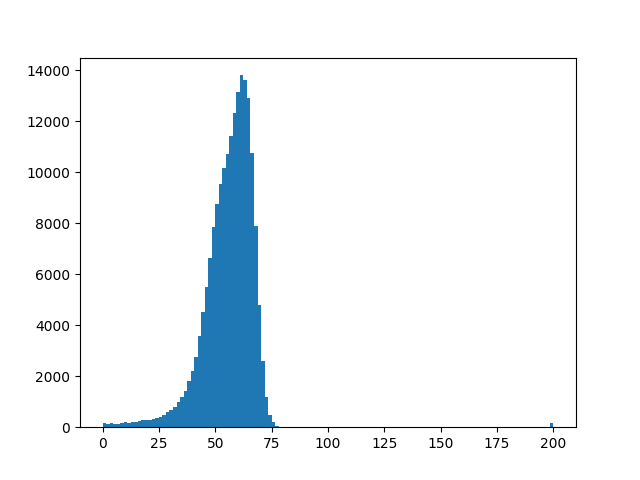

In [83]:
# Envelope detection
hri_abs = np.abs(hri_data)

# Log compression
hri_abs[hri_abs==0] = 10**-10
hri_frames = 20 * np.log10(hri_abs)
print(hri_data.shape)

# Do the same with LRI data for reference
lri_abs = np.abs(lri_data)
lri_abs[lri_abs==0] = 10**-10
lri_frames = 20 * np.log10(lri_abs)

# Plot histogram
if(1):
    %matplotlib widget
    data = np.abs(hri_frames[10, :, :]).flatten()
    plt.hist(data, bins=128)
    


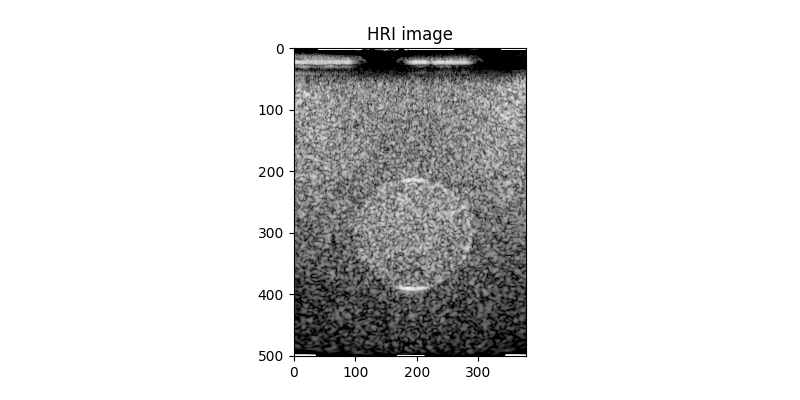

In [84]:
if(0):
    # Plot imported bmodes
    norm = plt.Normalize(40, 80, True)
    hri_frames_dim = hri_frames.shape
    if(hri_frames_dim[2] > hri_frames_dim[1] ):
        hri_frames = np.moveaxis(hri_frames, (0,1,2), (0,2,1))
    fig, ax0 = plt.subplots(1, 1, figsize=(8, 4))
    ax0.imshow(np.abs(hri_frames[100, :, :]), cmap='gray', norm=norm)
    ax0.set_title('HRI image')
 
    
if(1):
    # Plot B-modes
    norm = plt.Normalize(40, 84, True)
    hri_frames_dim = hri_frames.shape
    if(hri_frames_dim[2] > hri_frames_dim[1] ):
        hri_frames = np.moveaxis(hri_frames, (0,1,2), (0,2,1))


    lri_frames_dim = lri_frames.shape    
    if(lri_frames_dim[2] > lri_frames_dim[1] ):
        lri_frames = np.moveaxis(lri_frames, (0,1,2), (0,2,1))

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))
    ax0.imshow(np.abs(hri_frames[148, :, :]), cmap='gray', norm=norm)
    ax0.set_title('HRI image')
    ax1.imshow(np.abs(lri_frames[2, :, :]), cmap='gray', norm=norm)
    ax1.set_title('LRI image')


# Shear wave detection

In [85]:
# Axial displacement estimation from the series of beamformed frames
def displacement_estimation(de_input_data, z_gate, packet_size, c, fc, fs, mode='kasai'):
    # Create buffers
    img_z_px, img_x_px, N_frames = de_input_data.shape
    displacement_data = np.zeros((img_z_px, img_x_px, N_frames-packet_size+1))

    # Processing
    for i in range(packet_size, N_frames):
        # Get input data packet (packet_size * frames)
        X = de_input_data[:, :, i-packet_size : i-1]

        # Get Complex conjugate of X
        X_conj = np.conj(X)

        # Extract phase shift and perform spatial averaging
        P0 = np.sum(X[:-1,:,:-1] * X_conj[:-1,:,1:], axis=2)
        P0 = sp.signal.convolve2d(P0, np.ones((z_gate, 1)), 'valid')

        # Estimated doppler frequency
        f_d = np.angle(P0) / (2*np.pi)

        if mode == 'loupas':
            P1 = np.sum(X[:-1,:,:] * X_conj[1:,:,:], axis=2)
            P1 = sp.signal.convolve2d(P1, np.ones((z_gate, 1)), 'valid')

            # Estimated centeral frequency
            fc_shift = np.abs(np.angle(P1) / (2*np.pi*1/fs))

        # Obtain displacement
        if mode == 'loupas':
            d = c * f_d / (2*fc_shift)
        else:
            d = c * f_d / (2*fc)

        # Ensemble data
        displacement_data[z_gate//2 : -(z_gate//2), : , i-packet_size] = d
    
    return displacement_data


In [86]:
# Crop the data
nAngles = 3
hri_data = np.moveaxis(hri_data, [0,1], [2,1])
hri_data = hri_data[:, :, nAngles-1:-nAngles+1]
print(hri_data.shape)

(501, 379, 144)


In [87]:
# Invoke the function
ddata = displacement_estimation(de_input_data=hri_data, z_gate=8, packet_size=4, c=1540.0, fc=4.4e6, fs=65.0e6, mode='kasai')
# Convert to axial velocity
frame_pri = 200e-3
ddata = ddata / frame_pri; 
ddata.shape

(501, 379, 141)

(array([   5540.,    5618.,    5965.,    6125.,    6247.,    6442.,
           6557.,    6921.,    7268.,    7478.,    7871.,    7909.,
           8416.,    8696.,    8931.,    9435.,    9846.,   10098.,
          10837.,   11424.,   12125.,   12872.,   13791.,   14450.,
          15413.,   16338.,   17335.,   18275.,   19675.,   20718.,
          21993.,   23896.,   25888.,   27843.,   29736.,   32570.,
          35659.,   39309.,   43475.,   48532.,   54141.,   60885.,
          68823.,   78906.,   92358.,  109976.,  133753.,  163284.,
         200501.,  249692.,  309205.,  368898.,  431753.,  492628.,
         546196.,  594231.,  638401.,  695775.,  785048.,  911665.,
        1077606., 1293033., 1579390., 1929889., 2641963., 1727521.,
        1418058., 1131929.,  903377.,  727668.,  588222.,  476113.,
         387153.,  316609.,  261770.,  219850.,  187644.,  162374.,
         141730.,  125126.,  110634.,   98325.,   87527.,   77866.,
          69311.,   61618.,   54572.,   49119., 

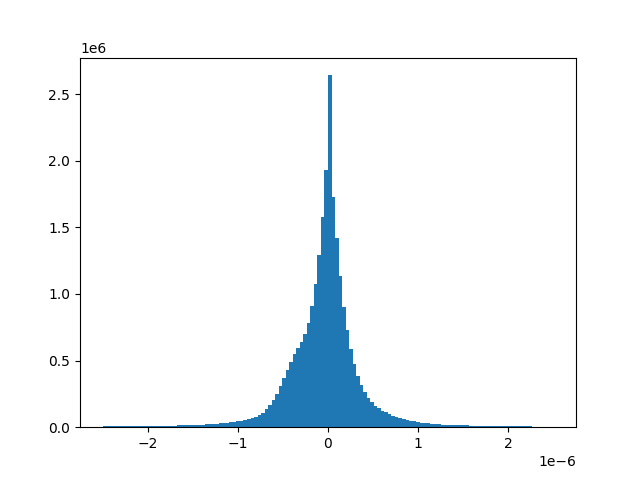

In [88]:
# Display displacements histogram
%matplotlib widget
data = ddata.flatten();
plt.hist(data, bins=128, range=[-2.5e-6, 2.5e-6])

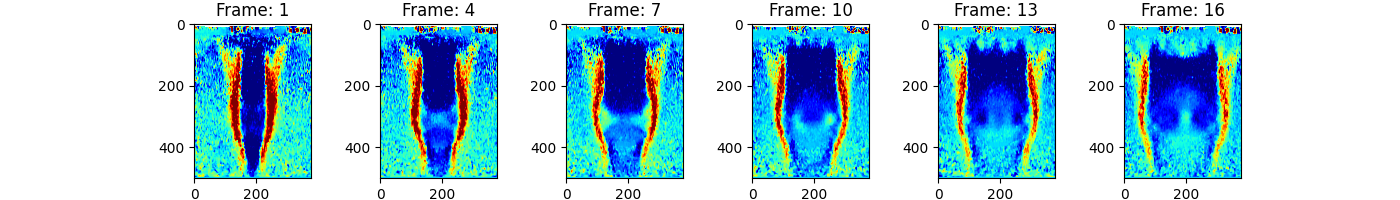

In [89]:
# Display shear wave propagation images
data = np.copy(ddata);
data[data>2e-6] = 2e-6
data[data<-1e-6] = -1e-6
norm = plt.Normalize(-1e-6, 2e-6, True)
frames = [1, 4, 7, 10, 13, 16, 20]

ax = [] * len(frames)
fig, ax = plt.subplots(1, 6, figsize=(14, 2))
frames = [1, 4, 7, 10, 13, 16]
for i in range(len(frames)):
    ax[i].imshow(data[:, :, frames[i]], cmap='jet', norm=norm)
    ax[i].set_title('Frame: ' + str(frames[i]))



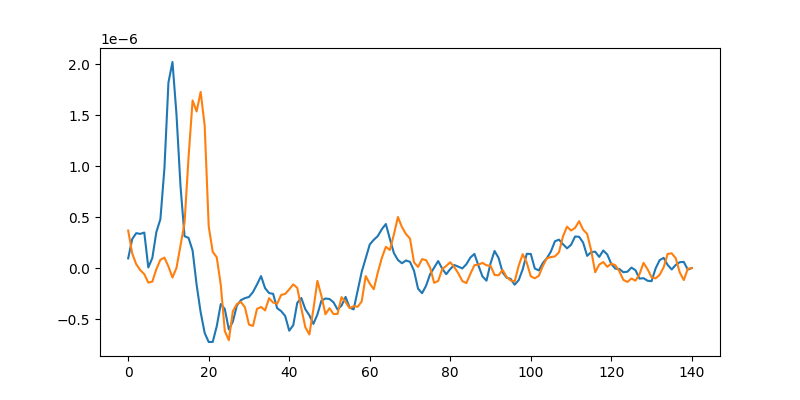

In [115]:
# Plot some profiles
%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(np.squeeze(ddata[300, 320-15, :]))
ax.plot(np.squeeze(ddata[300, 320+15, :]))

# Shear wave motion data filtering

In [91]:
# Input parameters
df_sws_range = [0.5, 4.0];
df_f_range   = [40.0, 1000.0];
df_k_range   = 0.9;
df_ddata     = np.copy(ddata);

In [92]:
# Perform zero padding of the input data
def nextpow2(x):
    return int(math.ceil(math.log2(x)))

nZ, nX, nFrames = df_ddata.shape
print(df_ddata.shape)
nX_padded = 2**nextpow2(nX)
nFrames_padded = 2**nextpow2(nFrames)
df_ddata_padded = np.pad(df_ddata, ((0,0), (0, nX_padded - nX), (0, nFrames_padded - nFrames)), 'constant')
print(df_ddata_padded.shape)
kX = [nX_padded, nFrames_padded] 

(501, 379, 141)
(501, 512, 256)


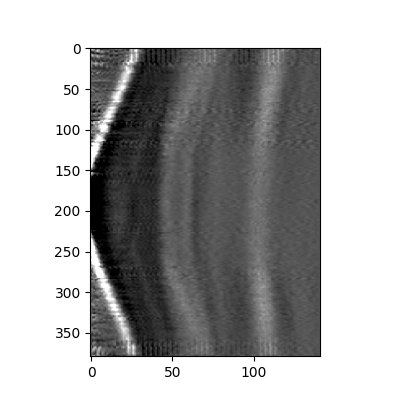

In [93]:
# Plot the slice
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(np.squeeze(df_ddata[240, :, :]), cmap='gray', norm=norm, aspect=0.5)

(501, 512, 256)


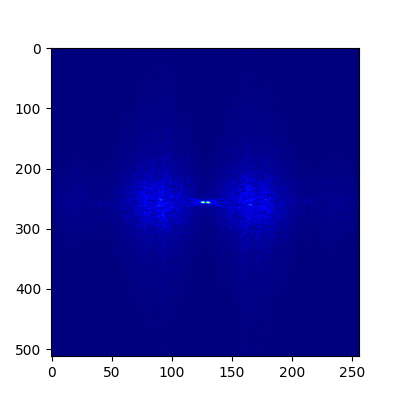

In [94]:
# Perform the 2-D FFT
X = sp.fft.fft2(df_ddata, s=kX, axes=(1, 2), overwrite_x=False)
X = sp.fft.fftshift(X)
print(X.shape)

# Print some slices in Fourier domain
Xabs = np.abs(X)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(np.squeeze(Xabs[240, :, :]), cmap='jet', aspect=0.5)

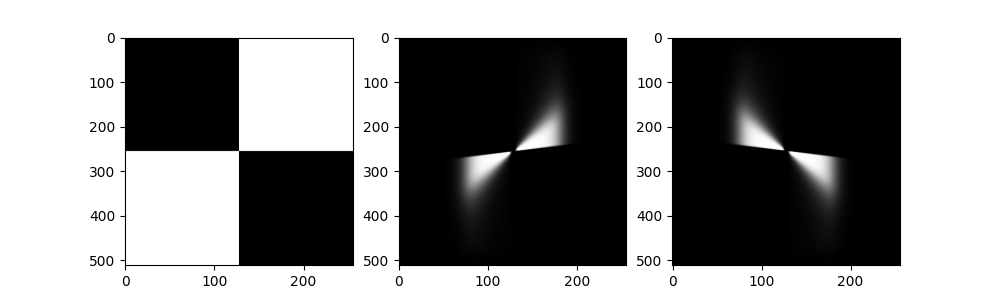

In [95]:
## Create masks for filtering

# Basic directional mask
mask = np.ones(kX)
mask[:int(np.floor(kX[0]/2)), :int(np.floor(kX[1]/2))] = 0
mask[int(np.floor(kX[0]/2)):, int(np.floor(kX[1]/2)):] = 0
mask_RLraw = np.copy(mask)

# Add filtering ranges
vmin = df_sws_range[0]
vmax = df_sws_range[1]

# Precalc values
fs = 1.0 / 200e-6
w_s_max = np.ceil(df_f_range[1] * kX[1] / fs)
w_s_min = np.ceil(df_f_range[0] * kX[1] / fs)
k_s_max = np.ceil(df_k_range * kX[0]/2)

# Experimantal filter functions parameters
a_w1 = 2;
a_w2 = 0.2;
a_k  = 0.1;
a_v1 = 10;
a_v2 = 4; 

mask_f = mask;
for w in range(kX[1]):
    for k in range(kX[0]):
        w_s = abs(w - kX[1] / 2)
        k_s = abs(k - kX[0] / 2)
        if(k_s == 0):
            k_s = 1e-6;
        
        v = abs(w_s / k_s)

        # Calc filter coefficients
        fw1 = 1 / (1 + np.exp(-a_w1 * (w_s - w_s_min)))
        fw2 = 1 - 1 / (1 + np.exp(-a_w2 * (w_s - w_s_max)))
        fw = min(fw1, fw2)
        
        fk = 1 - 1 / (1 + np.exp(-a_k * (k_s - k_s_max)))
        
        fv1 = 1 / (1 + np.exp(-a_v1 * (v - vmin)))
        fv2 = 1 - 1 / (1 + np.exp(-a_v2 * (v - vmax)))
        fv = min(fv1, fv2)

        mask_f[k, w] = mask_f[k, w] * fw * fk * fv
        
mask_f[int(np.floor(kX[0]/2)), int(np.floor(kX[1]/2))] = 0;
mask_RL = mask_f
mask_LR = np.flipud(mask_f);

# Plot the masks
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 3))
ax0.imshow(np.squeeze(mask_RLraw), cmap='gray', aspect=0.5)
ax1.imshow(np.squeeze(mask_RL),   cmap='gray', aspect=0.5)
ax2.imshow(np.squeeze(mask_LR),   cmap='gray', aspect=0.5)

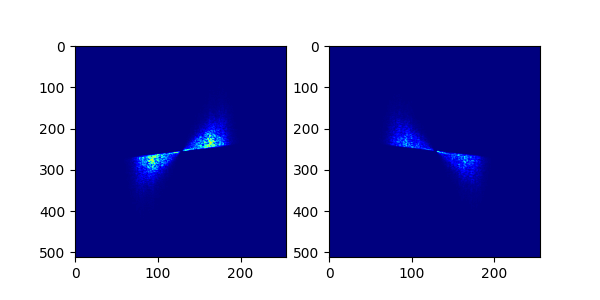

In [96]:
# Filtering in k-omega space
X1 = X * mask_RL
X2 = X * mask_LR

# Plot the results
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(6, 3))
ax0.imshow(np.squeeze(np.abs(X1[240, :, :])), cmap='jet', aspect=0.5)
ax1.imshow(np.squeeze(np.abs(X2[240, :, :])), cmap='jet', aspect=0.5)

In [97]:
# Perform the Inverse 2-D FFT
X1 = sp.fft.fftshift(X1)
X2 = sp.fft.fftshift(X2)

X1 = np.real(sp.fft.ifft2(X1, axes=(1, 2)))
X2 = np.real(sp.fft.ifft2(X2, axes=(1, 2)))
ddata.shape
X1 = X1[:, 0:ddata.shape[1], 0:ddata.shape[2]]
X2 = X2[:, 0:ddata.shape[1], 0:ddata.shape[2]]
print(X1.shape)

(501, 379, 141)


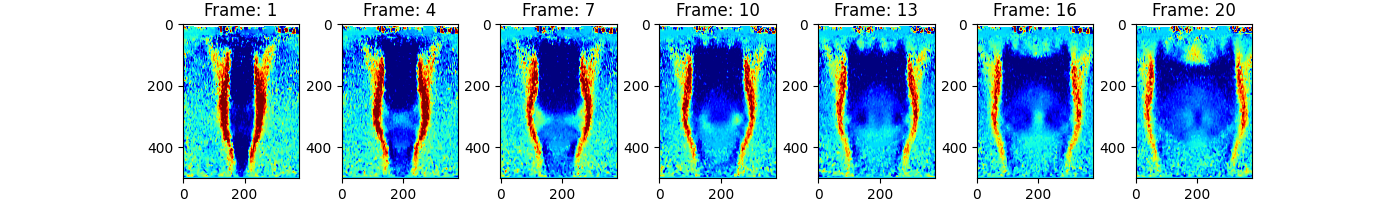

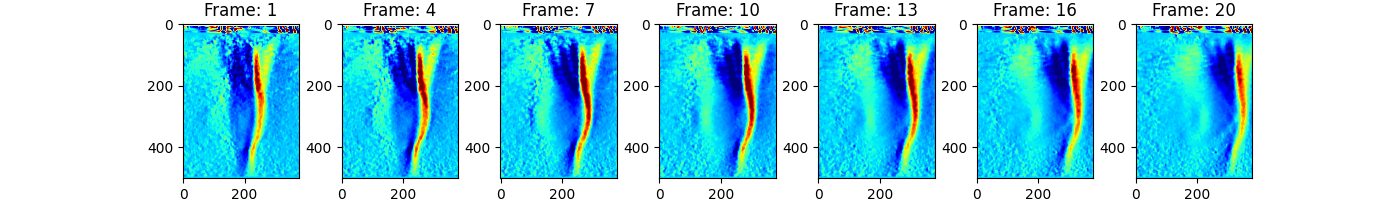

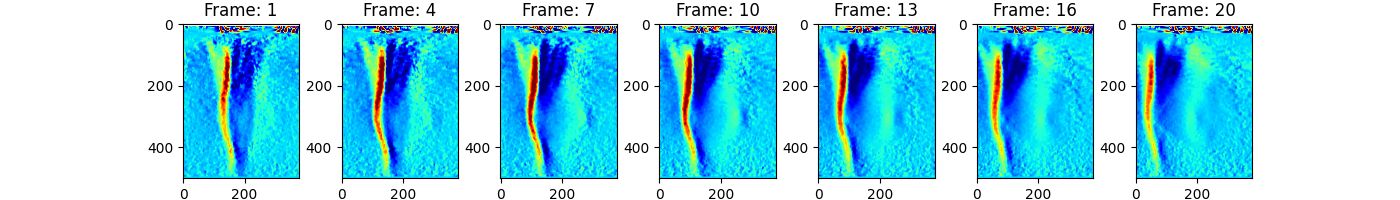

In [98]:
## Display shear wave motion filtering results
frames = [1, 4, 7, 10, 13, 16, 20]
norm = plt.Normalize(-1e-6, 2e-6, True)

# Unfiltered
data = np.copy(ddata);
data[data>2e-6] = 2e-6
data[data<-1e-6] = -1e-6
ax = [0] * len(frames)
fig, ax = plt.subplots(1, len(frames), figsize=(14, 2))
for i in range(len(frames)):
    ax[i].imshow(data[:, :, frames[i]], cmap='jet', norm=norm)
    ax[i].set_title('Frame: ' + str(frames[i]))

# Filtered 1    
data = np.copy(X1);
data[data>2e-6] = 2e-6
data[data<-1e-6] = -1e-6
ax = [0] * (len(frames)+1)
fig, ax = plt.subplots(1, len(frames), figsize=(14, 2))
for i in range(len(frames)):
    ax[i].imshow(data[:, :, frames[i]], cmap='jet', norm=norm)
    ax[i].set_title('Frame: ' + str(frames[i]))

# Filtered 2  
data = np.copy(X2);
data[data>2e-6] = 2e-6
data[data<-1e-6] = -1e-6
ax = [0] * len(frames)
fig, ax = plt.subplots(1, len(frames), figsize=(14, 2))
for i in range(len(frames)):
    ax[i].imshow(data[:, :, frames[i]], cmap='jet', norm=norm)
    ax[i].set_title('Frame: ' + str(frames[i]))    

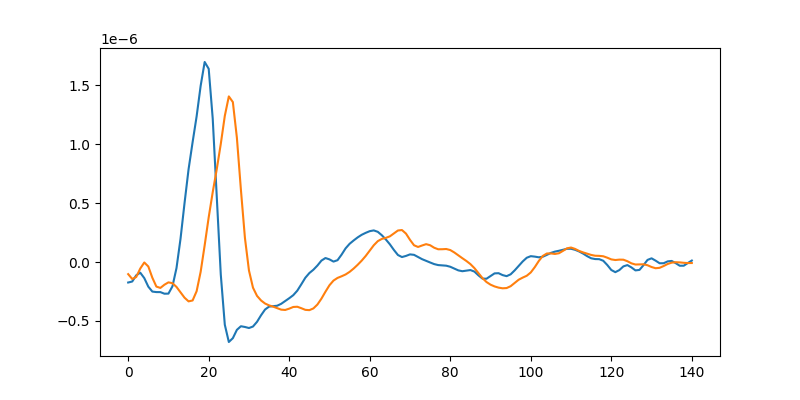

In [116]:
# Plot some profiles
%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(np.squeeze(X1[200, 350-15, :]))
ax.plot(np.squeeze(X1[200, 350+15, :]))

# Local shear wave speed estimation

## FFT-based correlation approach

In [117]:
# Input parameters
swse_interp_factor = 10;
swse_d         = 30;
swse_frames    = [0, 99];
swse_SWV_range = [0.5, 4.0];
swse_x_range   = [0, X1.shape[1]-1]; 
swse_ddata_LR  = np.copy(X1);
swse_ddata_RL  = np.copy(X2);
swse_correction_factor = 1;
swse_ddata_RL.shape

(501, 379, 141)

In [118]:
# Crop input data
swse_ddata_LR = swse_ddata_LR[10:-30, :, swse_frames[0]:swse_frames[1]] 
swse_ddata_RL = swse_ddata_RL[10:-30, :, swse_frames[0]:swse_frames[1]] 
out_dim = [swse_ddata_RL.shape[0], swse_ddata_RL.shape[1]]
print(out_dim)

# Process column range
xL = swse_x_range[0] - int(np.ceil(swse_d /2));
xR = swse_x_range[1] + int(np.ceil(swse_d /2));
if(xL < 0):
    xL = 0;

if(xR > out_dim[1]):
    xR = out_dim[1]  

swse_ddata_LR = swse_ddata_LR[:, xL:xR, :];


[461, 379]


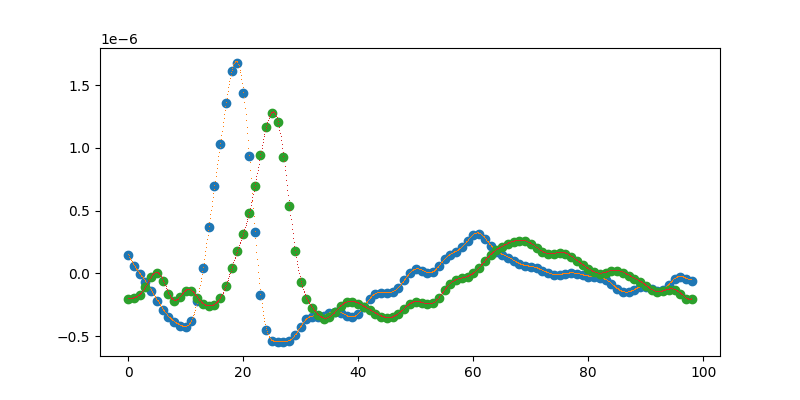

In [120]:
# Data interpolation along slow-time dimension
x = np.arange(0, swse_ddata_LR.shape[2], 1)
y = np.copy(swse_ddata_LR)
y[np.isnan(y)]=0
f = sp.interpolate.interp1d(x=x, y=y, kind='cubic', axis=2)
xnew = np.arange(0, swse_ddata_LR.shape[2]-1, 1/swse_interp_factor)
ynew = f(xnew) 

# Plot example particle velocity profile
if(1):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(x, np.squeeze(y[200, 350-15, :]), 'o', xnew, np.squeeze(ynew[200, 350-15, :]), ',')
    ax.plot(x, np.squeeze(y[200, 350+15, :]), 'o', xnew, np.squeeze(ynew[200, 350+15, :]), ',')

In [121]:
# DC offset cancellation
print(ynew.shape)
m = np.mean(ynew, axis=2)
ynew = np.transpose(ynew, [2,0,1])
print(ynew.shape)
print(m.shape)
ddata_mi = np.subtract(ynew, m)
ddata_mi = np.transpose(ddata_mi, [1,2,0])
print(ddata_mi.shape)


(461, 379, 980)
(980, 461, 379)
(461, 379)
(461, 379, 980)


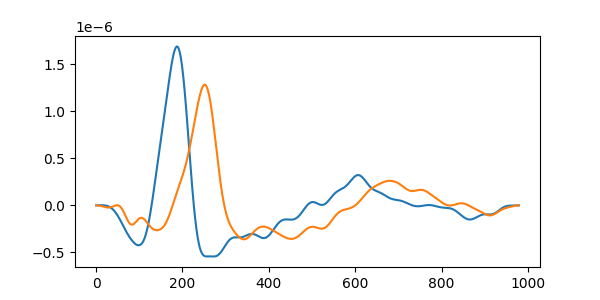

In [122]:
## Apply window function
# Generate window
N = ddata_mi.shape[2]
w = sp.signal.windows.tukey(N, alpha=0.2, sym=True)

# Draw window function
if(0):
    plt.figure()
    plt.plot(w)
    plt.title("Tukey window")
    plt.ylabel("Amplitude")
    plt.xlabel("Sample")
    plt.ylim([0, 1.1])
    
# Data windowing
ddata_w = ddata_mi * w

# Plot the profile after pre-processing
if(1):
    fig, ax0 = plt.subplots(1, 1, figsize=(6, 3))
    ax0.plot(np.squeeze(ddata_w[200, 350-swse_d//2, :]))
    ax0.plot(np.squeeze(ddata_w[200, 350+swse_d//2, :]))
    

In [123]:
## Perform the correlation algorithm in Fourier domain
# Zero padding
N = ddata_w.shape[2]
print(N)
option = 0
if(option==0):
    N_padded = N
elif(option==1):
    N_padded = 2**nextpow2(N)
else:
    N_padded = 2 * N
    
ddata_w = np.pad(ddata_w, ((0,0), (0, 0), (0, N_padded - N)), 'constant')

# Compute the FFT along the slow-time dim
X = sp.fft.fft(ddata_w, axis=2)

# Correlation in frequency domain and back to time-domain
Xa = X[:, 0:X.shape[1]-swse_d, :]
Xb = X[:, swse_d:X.shape[1], :]
c = np.real(sp.fft.ifft(Xa * np.conj(Xb), axis=2))

# Shift zero
c = np.concatenate((c[:, :, c.shape[2]//2:], c[:, :, :c.shape[2]//2]), axis=2)

# Normalize the correlation values
txa = ddata_w[:, 0:ddata_w.shape[1]-swse_d, :]
txb = ddata_w[:, swse_d:ddata_w.shape[1], :]
Rxa = np.sum(txa * txa, axis=2)
Rxb = np.sum(txb * txb, axis=2)
c = np.transpose(c,[2, 0, 1])
c = c / (np.sqrt(Rxa) * np.sqrt(Rxb))
c = np.transpose(c, [1,2,0])

980


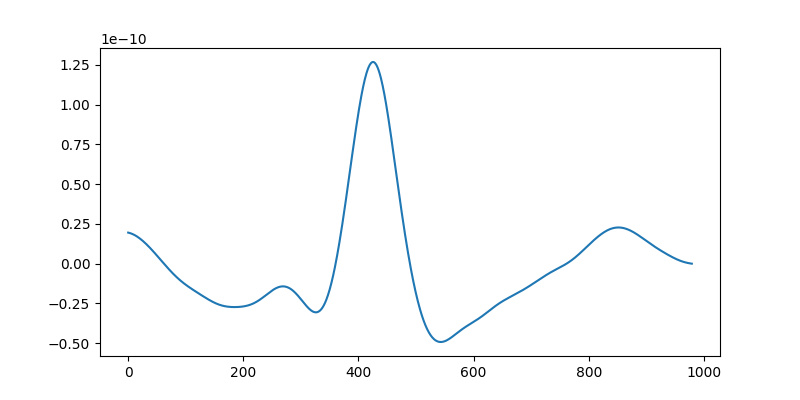

In [124]:
s1 = np.squeeze(ddata_w[200, 350-swse_d//2, :]);
s2 = np.squeeze(ddata_w[200, 350+swse_d//2, :]);
# Correlate
corr = sp.signal.correlate(s1, s2, mode='same', method='fft')
%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plt.cla()
plt.plot(corr)
plt.show()

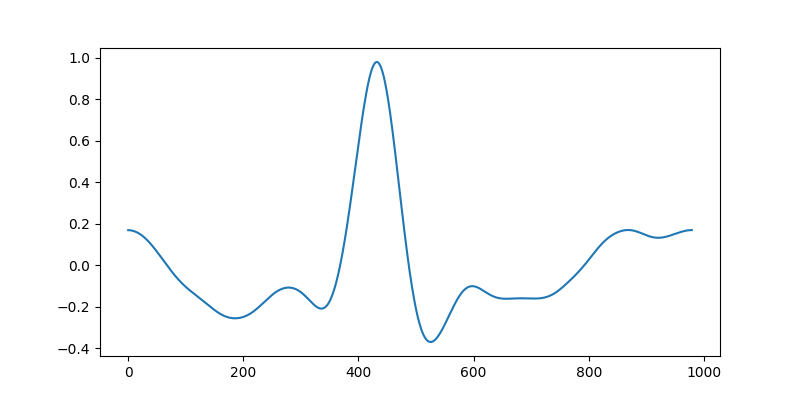

In [125]:
%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plt.cla()
plt.plot(np.squeeze(c[200, 320, :]))
plt.show()

In [128]:
# Calc propagation delay
px_pitch = 0.1e-3;
FRI = 200e-6;
rmax_idx = np.argmax(corr, axis=0)
print(rmax_idx)
rmax_idx = np.abs(rmax_idx - corr.shape[0]//2)
print(corr.shape[0]//2)
print(rmax_idx)
ds = px_pitch * swse_d
dt = FRI * rmax_idx / swse_interp_factor
swv = ds / dt

print(ds)
print(dt)
print(swv)

425
490
65
0.003
0.0013000000000000002
2.3076923076923075


In [110]:
## SWS estimation post-processing
# find lag of max correlation
r = np.amax(c, axis=2)
rmax_idx = np.argmax(c, axis=2)

# apply zero shift
rmax_idx = np.abs(rmax_idx - c.shape[2]//2)
rmax_idx[rmax_idx==0] = 1 

# Calc propagation delay
px_pitch = 0.298e-3;
FRI = 200e-6;
ds = px_pitch * swse_d
dt = FRI * rmax_idx / swse_interp_factor
sws_map = ds / dt

#sws_map[sws_map < swse_SWV_range[0]] = swse_SWV_range[0]
#sws_map[sws_map > swse_SWV_range[1]] = swse_SWV_range[1]

# Assign results
SWV = np.zeros(out_dim)
SWV_r = np.zeros(out_dim)
SWV[:, int(np.ceil(xL + swse_d/2)) : int(np.ceil(xR-swse_d/2))] = sws_map
SWV_r[:, xL + int(np.ceil(swse_d/2)) : int(np.ceil(xR-swse_d/2))] = r

# Limit the values
sws_map = np.clip(sws_map, swse_SWV_range[0], swse_SWV_range[1])


(array([13830.,     0.,     0.,  7250.,  4140.,  2327.,  1129.,  1064.,
          994.,  1206.,  1158.,   979.,  1361.,  1411.,  1350.,  1273.,
         1523.,  1424.,  1309.,  1743.,  2841.,  3115.,  4569.,  5180.,
        13550., 10599., 10232.,  8662.,  6220.,  4808.,  2348.,  4941.,
         2581.,  5160.,  2303.,  2241.,  2074.,  2051.,  2128.,  2118.,
         2262.,  2174.,  1896.,  1543.,     0.,  1431.,  1255.,     0.,
         1156.,  1064.,     0.,   977.,     0.,   910.,     0.,   902.,
            0.,   848.,     0.,   760.,     0.,     0.,   773.,     0.,
          734.,     0.,     0.,   710.,     0.,     0.,   673.,     0.,
            0.,     0.,   645.,     0.,     0.,     0.,   641.,     0.,
            0.,     0.,   583.,     0.,     0.,     0.,     0.,   598.,
            0.,     0.,     0.,     0.,     0.,   594.,     0.,     0.,
            0.,     0.,     0.,   655.,     0.]),
 array([ 0.        ,  0.0990099 ,  0.1980198 ,  0.2970297 ,  0.3960396 ,
         0.49

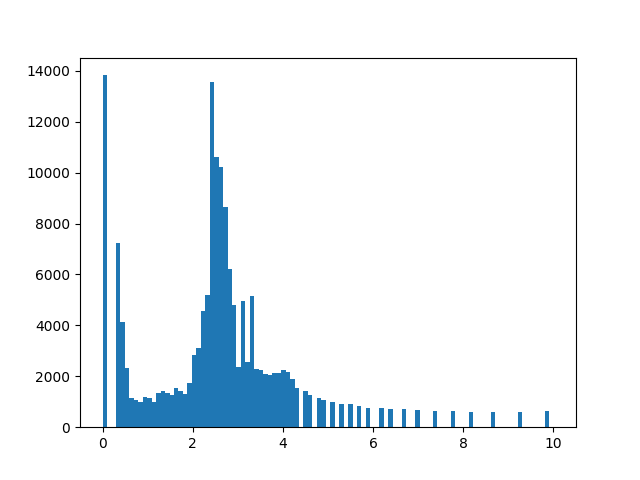

In [111]:
# Display SWS histogram
%matplotlib widget
data = SWV.flatten();
plt.hist(data, bins=101, range=[0, 10])

Text(0.5, 1.0, 'r')

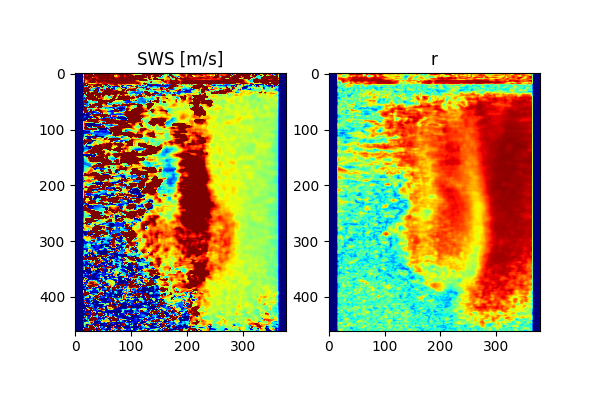

In [112]:
## Display the results
norm_sws = plt.Normalize(swse_SWV_range[0], swse_SWV_range[1], True)
norm_r   = plt.Normalize(0, 1, True)

fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(6, 4))
ax0.imshow(SWV, cmap='jet', norm=norm_sws)
ax0.set_title('SWS [m/s]')

ax1.imshow(SWV_r, cmap='jet', norm=norm_r)
ax1.set_title('r')

# Post-processing

## Image compounding

## Image filtering

## Data presentation

In [36]:
print(c.shape[2])

1960
